In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import collections
import time
import joblib
from tqdm import tqdm
from math import ceil

In [2]:
# Đường dẫn đến các thư mục dữ liệu
data_train_path = '/kaggle/input/vegetable-classification/train'
data_val_path = '/kaggle/input/vegetable-classification/val'
data_test_path = '/kaggle/input/vegetable-classification/test'

IMG_WIDTH = 128
IMG_HEIGHT = 128

# Hàm để tải ảnh và nhãn từ một thư mục
def load_images_from_folder(folder_path, img_width, img_height):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder_path))
    label_map = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for filename in tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
                try:
                    img_path = os.path.join(class_path, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, (img_width, img_height))
                        images.append(img)
                        labels.append(label_map[class_name])
                    else:
                        print(f"Warning: Could not read image {img_path}")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
    return np.array(images), np.array(labels), class_names, label_map

# Tải dữ liệu
X_train_img, y_train, class_names, label_map = load_images_from_folder(data_train_path, IMG_WIDTH, IMG_HEIGHT)
X_val_img, y_val, _, _ = load_images_from_folder(data_val_path, IMG_WIDTH, IMG_HEIGHT)
X_test_img, y_test, _, _ = load_images_from_folder(data_test_path, IMG_WIDTH, IMG_HEIGHT)

print(f"Number of training images: {len(X_train_img)}")
print(f"Number of validation images: {len(X_val_img)}")
print(f"Number of test images: {len(X_test_img)}")
print(f"Class names: {class_names}")
print(f"Label map: {label_map}")

Loading tomato: 100%|██████████| 150/150 [00:01<00:00, 87.42it/s]

Number of training images: 7000
Number of validation images: 1500
Number of test images: 1500
Class names: ['asparagus', 'banana', 'broccoli', 'carrot', 'corn', 'eggplant', 'orange', 'pineapple', 'potato', 'tomato']
Label map: {'asparagus': 0, 'banana': 1, 'broccoli': 2, 'carrot': 3, 'corn': 4, 'eggplant': 5, 'orange': 6, 'pineapple': 7, 'potato': 8, 'tomato': 9}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


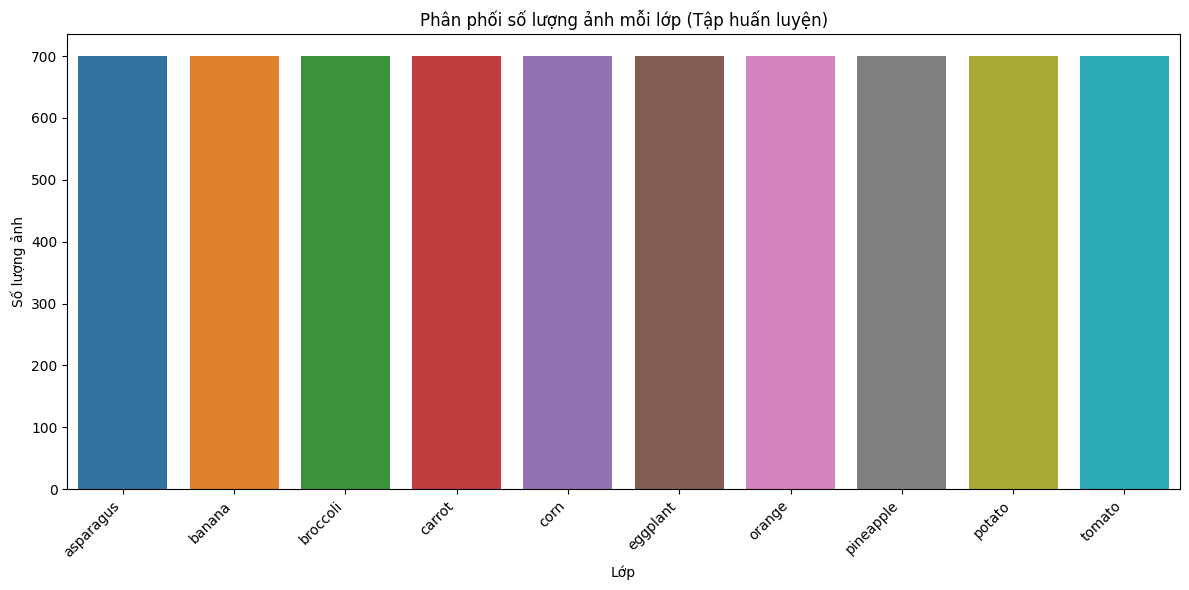

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


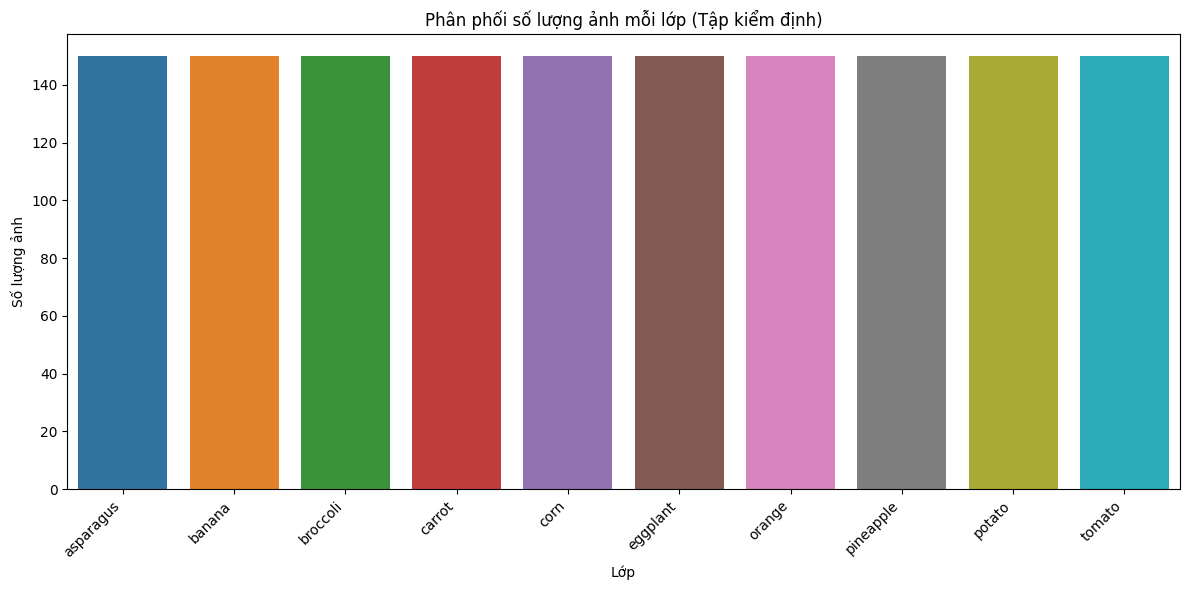

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


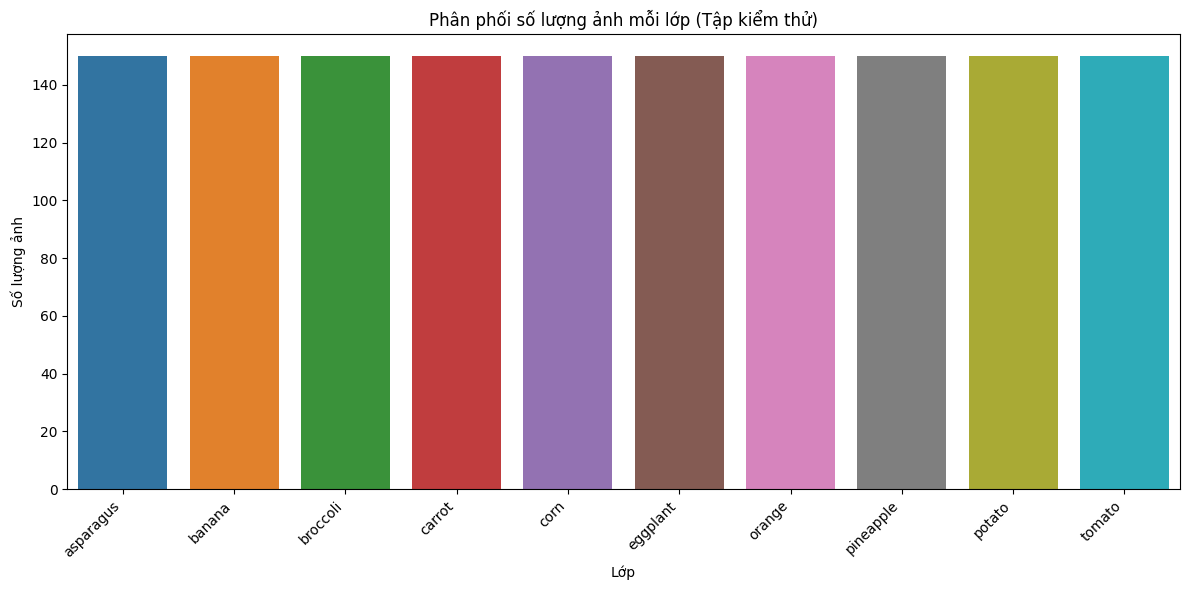


Hiển thị ảnh mẫu từ tập huấn luyện:


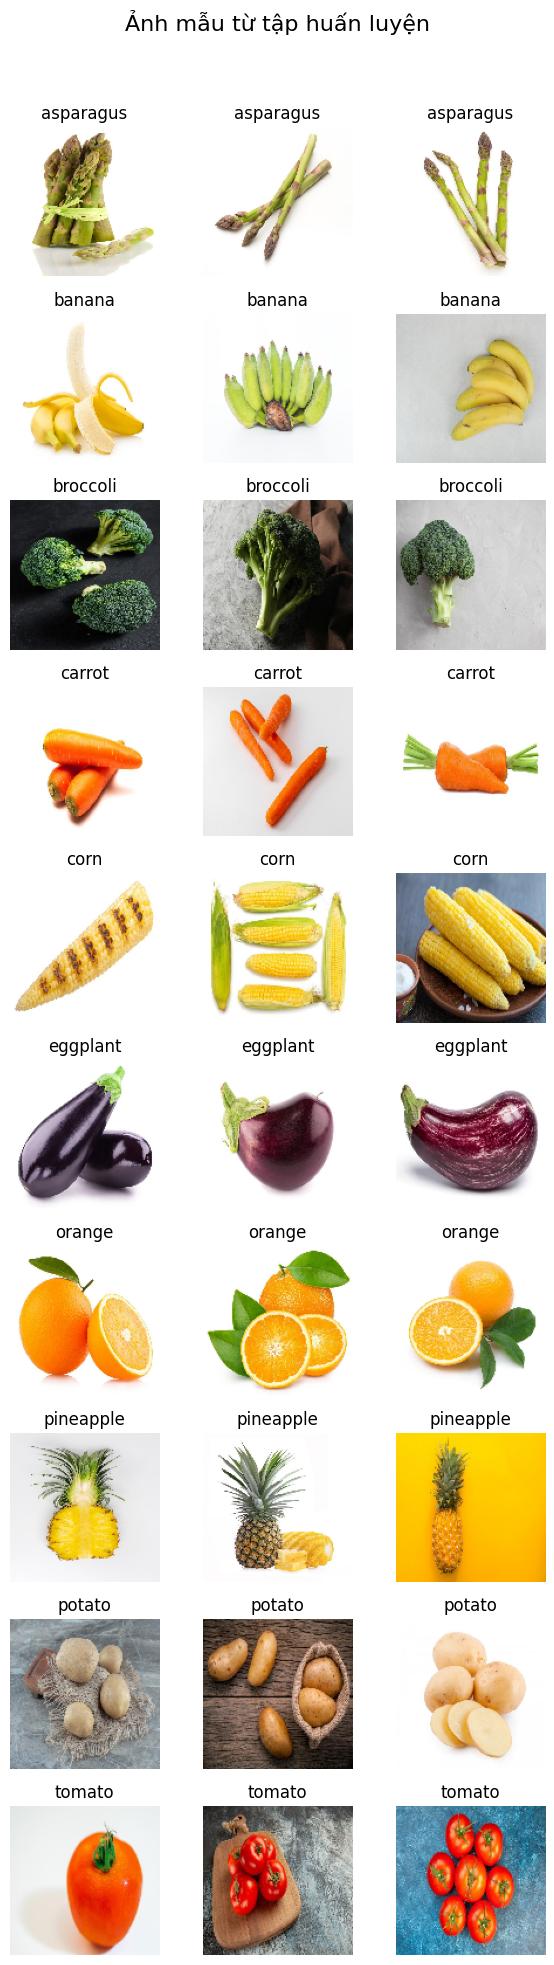

In [3]:
def plot_class_distribution(y, title_prefix, class_names_list):
    counter = collections.Counter(y)
    counts = [counter[i] for i in range(len(class_names_list))]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_names_list, y=counts)
    plt.title(f'Phân phối số lượng ảnh mỗi lớp ({title_prefix})')
    plt.xlabel('Lớp')
    plt.ylabel('Số lượng ảnh')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_class_distribution(y_train, "Tập huấn luyện", class_names)
plot_class_distribution(y_val, "Tập kiểm định", class_names)
plot_class_distribution(y_test, "Tập kiểm thử", class_names)

def show_sample_images(images, labels, class_names_list, num_samples_per_class=2, title="Ảnh mẫu từ tập dữ liệu"):
    num_classes = len(class_names_list)
    plt.figure(figsize=(num_samples_per_class * 2, num_classes * 2))
    
    for i, class_name in enumerate(class_names_list):
        class_indices = np.where(labels == i)[0]
        if len(class_indices) > 0:
            sample_indices = np.random.choice(class_indices, min(num_samples_per_class, len(class_indices)), replace=False)
            for j, sample_idx in enumerate(sample_indices):
                plt.subplot(num_classes, num_samples_per_class, i * num_samples_per_class + j + 1)
                img_rgb = cv2.cvtColor(images[sample_idx], cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                plt.title(f"{class_names_list[i]}")
                plt.axis('off')
        else:
             for j in range(num_samples_per_class):
                plt.subplot(num_classes, num_samples_per_class, i * num_samples_per_class + j + 1)
                plt.text(0.5, 0.5, 'N/A', horizontalalignment='center', verticalalignment='center')
                plt.title(f"{class_names_list[i]}")
                plt.axis('off')


    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("\nHiển thị ảnh mẫu từ tập huấn luyện:")
show_sample_images(X_train_img, y_train, class_names, num_samples_per_class=3, title="Ảnh mẫu từ tập huấn luyện")

In [4]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [5]:
def extract_haralick_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_image, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast').ravel()
    dissimilarity = graycoprops(glcm, 'dissimilarity').ravel()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel()
    energy = graycoprops(glcm, 'energy').ravel()
    correlation = graycoprops(glcm, 'correlation').ravel()
    asm = graycoprops(glcm, 'ASM').ravel()
    
    haralick_features = np.hstack([
        np.mean(contrast), np.std(contrast),
        np.mean(dissimilarity), np.std(dissimilarity),
        np.mean(homogeneity), np.std(homogeneity),
        np.mean(energy), np.std(energy),
        np.mean(correlation), np.std(correlation),
        np.mean(asm), np.std(asm)
    ])
    return haralick_features

In [6]:
def extract_lbp_features(image, P=24, R=3, method='uniform'):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, P, R, method=method)
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7) 
    return hist

In [7]:
def extract_hu_moments(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray_image)
    hu_moments = cv2.HuMoments(moments).flatten()
    for i in range(0, 7):
        hu_moments[i] = -1 * np.sign(hu_moments[i]) * np.log10(abs(hu_moments[i]) + 1e-7)
    return hu_moments

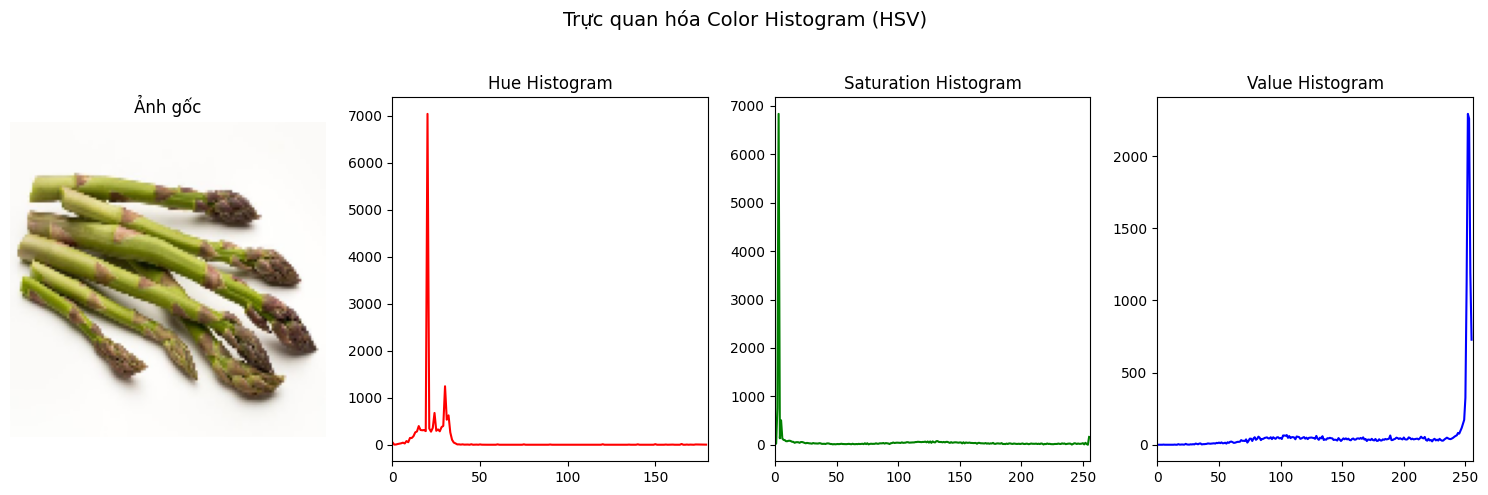

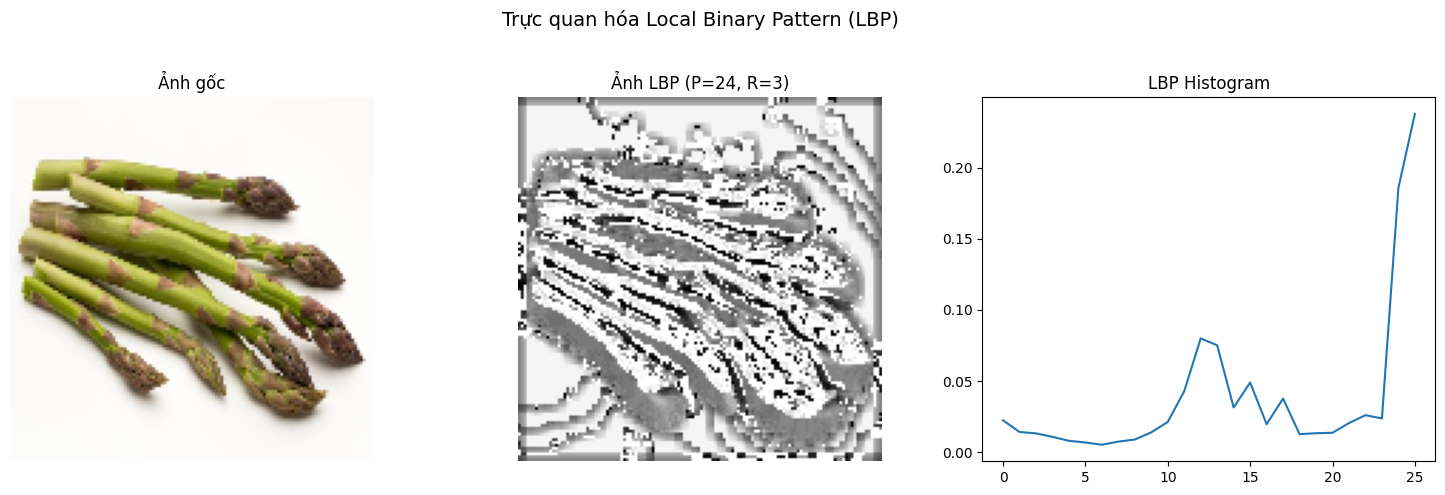

In [8]:
if len(X_train_img) > 0:
    sample_image_for_features = X_train_img[0]
    sample_image_rgb = cv2.cvtColor(sample_image_for_features, cv2.COLOR_BGR2RGB)
    sample_image_gray = cv2.cvtColor(sample_image_for_features, cv2.COLOR_BGR2GRAY)

    # Color Histogram
    hsv_sample = cv2.cvtColor(sample_image_for_features, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv_sample], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([hsv_sample], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv_sample], [2], None, [256], [0, 256])

    plt.figure(figsize=(15, 5))
    plt.subplot(141)
    plt.imshow(sample_image_rgb)
    plt.title('Ảnh gốc')
    plt.axis('off')

    plt.subplot(142)
    plt.plot(hist_h, color='r')
    plt.title('Hue Histogram')
    plt.xlim([0, 180])

    plt.subplot(143)
    plt.plot(hist_s, color='g')
    plt.title('Saturation Histogram')
    plt.xlim([0, 256])

    plt.subplot(144)
    plt.plot(hist_v, color='b')
    plt.title('Value Histogram')
    plt.xlim([0, 256])
    plt.suptitle("Trực quan hóa Color Histogram (HSV)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # LBP
    P_lbp_vis, R_lbp_vis = 24, 3
    lbp_image = local_binary_pattern(sample_image_gray, P_lbp_vis, R_lbp_vis, method='uniform')
    lbp_hist_vis = extract_lbp_features(sample_image_for_features, P=P_lbp_vis, R=R_lbp_vis)

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(sample_image_rgb)
    plt.title('Ảnh gốc')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(lbp_image, cmap='gray')
    plt.title(f'Ảnh LBP (P={P_lbp_vis}, R={R_lbp_vis})')
    plt.axis('off')
    
    plt.subplot(133)
    plt.plot(lbp_hist_vis)
    plt.title('LBP Histogram')
    plt.suptitle("Trực quan hóa Local Binary Pattern (LBP)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("Không có ảnh mẫu để trực quan hóa đặc trưng.")

In [9]:
feature_names_list = []
def extract_features_for_dataset_rf(images, is_first_call=False):
    global feature_names_list
    if is_first_call: feature_names_list = []

    all_features_list = []
    pbar = tqdm(images, desc="Extracting features for RF")
    for i, img in enumerate(pbar):
        color_hist_features = extract_color_histogram(img)
        haralick_features = extract_haralick_features(img)
        lbp_features = extract_lbp_features(img)
        hu_features = extract_hu_moments(img)

        combined_features = np.hstack([
            color_hist_features,
            haralick_features,
            lbp_features,
            hu_features,
        ])
        all_features_list.append(combined_features)

        if is_first_call and i == 0:
            feature_names_list.extend([f'color_hist_{j}' for j in range(len(color_hist_features))])
            haralick_props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'asm']
            haralick_stats = ['mean', 'std']
            feature_names_list.extend([f'haralick_{prop}_{stat}' for prop in haralick_props for stat in haralick_stats])
            feature_names_list.extend([f'lbp_{j}' for j in range(len(lbp_features))])
            feature_names_list.extend([f'hu_{j}' for j in range(len(hu_features))])
            pbar.set_postfix_str(f"Total features per image: {len(feature_names_list)}")


    return np.array(all_features_list)

In [10]:
print("\nTrích xuất đặc trưng cho tập huấn luyện...")
X_train_features_rf = extract_features_for_dataset_rf(X_train_img, is_first_call=True)
print("Trích xuất đặc trưng cho tập kiểm định...")
X_val_features_rf = extract_features_for_dataset_rf(X_val_img)
print("Trích xuất đặc trưng cho tập kiểm thử...")
X_test_features_rf = extract_features_for_dataset_rf(X_test_img)

print(f"\nShape of RF training features: {X_train_features_rf.shape}")
print(f"Shape of RF validation features: {X_val_features_rf.shape}")
print(f"Shape of RF test features: {X_test_features_rf.shape}")
if feature_names_list:
    print(f"Total number of extracted features per image: {len(feature_names_list)}")


Trích xuất đặc trưng cho tập huấn luyện...


Extracting features for RF: 100%|██████████| 7000/7000 [08:49<00:00, 13.21it/s, Total features per image: 557]


Trích xuất đặc trưng cho tập kiểm định...


Extracting features for RF: 100%|██████████| 1500/1500 [01:53<00:00, 13.18it/s]


Trích xuất đặc trưng cho tập kiểm thử...


Extracting features for RF: 100%|██████████| 1500/1500 [01:50<00:00, 13.53it/s]


Shape of RF training features: (7000, 557)
Shape of RF validation features: (1500, 557)
Shape of RF test features: (1500, 557)
Total number of extracted features per image: 557


In [11]:
print("Kiểm tra giá trị NaN/Infinite trong các đặc trưng:")
print(f"NaN in RF train features before processing: {np.isnan(X_train_features_rf).sum()}")
print(f"Inf in RF train features before processing: {np.isinf(X_train_features_rf).sum()}")
# Xử lý NaN/Inf nếu có
X_train_features_rf = np.nan_to_num(X_train_features_rf, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
X_val_features_rf = np.nan_to_num(X_val_features_rf, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
X_test_features_rf = np.nan_to_num(X_test_features_rf, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
print(f"NaN in RF train features after processing: {np.isnan(X_train_features_rf).sum()}")
print(f"Inf in RF train features after processing: {np.isinf(X_train_features_rf).sum()}")

Kiểm tra giá trị NaN/Infinite trong các đặc trưng:
NaN in RF train features before processing: 0
Inf in RF train features before processing: 0
NaN in RF train features after processing: 0
Inf in RF train features after processing: 0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

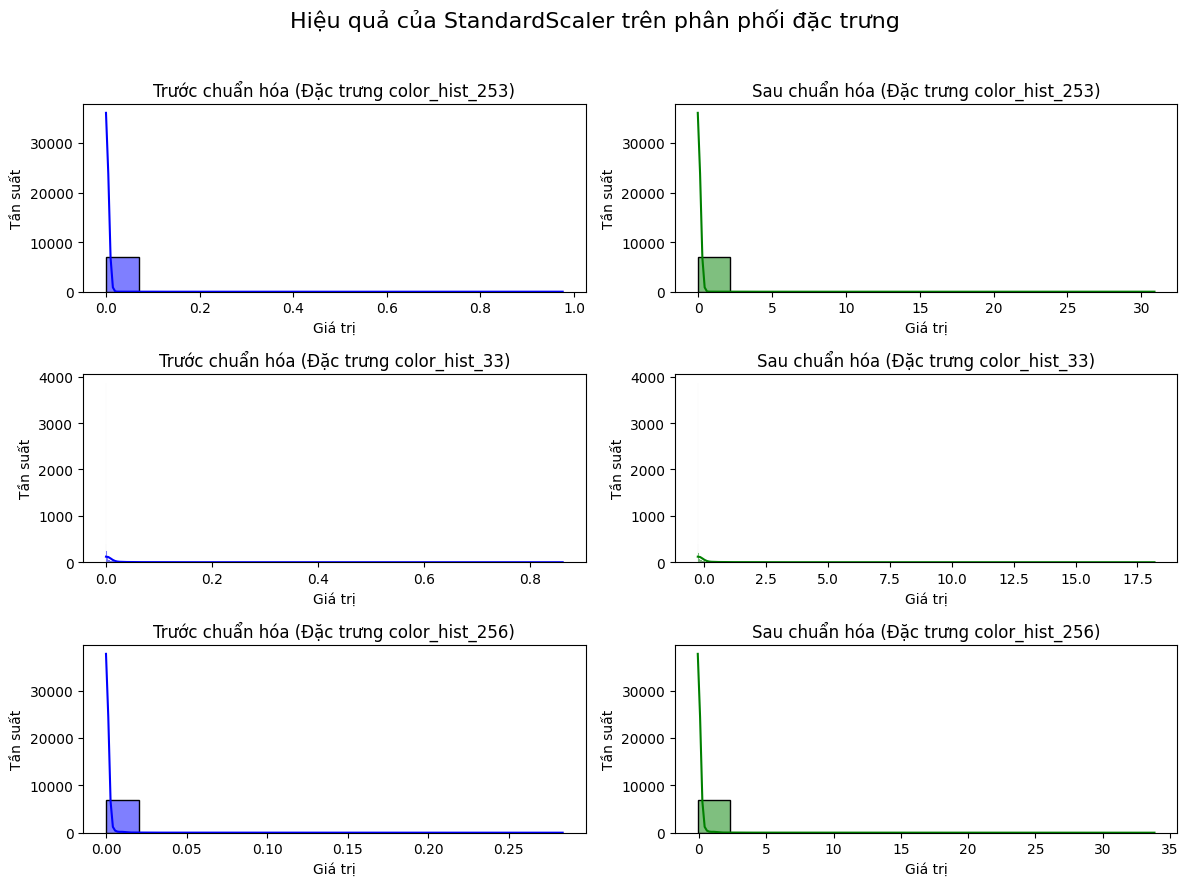

In [12]:
scaler_rf = StandardScaler()
X_train_processed_rf = scaler_rf.fit_transform(X_train_features_rf)
X_val_processed_rf = scaler_rf.transform(X_val_features_rf)
X_test_processed_rf = scaler_rf.transform(X_test_features_rf)

if X_train_features_rf.shape[0] > 0 and X_train_features_rf.shape[1] > 3: 
    num_features_to_plot_scaling = min(3, X_train_features_rf.shape[1])
    fig, axes = plt.subplots(num_features_to_plot_scaling, 2, figsize=(12, 3 * num_features_to_plot_scaling))
    if num_features_to_plot_scaling == 1: axes = np.array([axes])

    for i in range(num_features_to_plot_scaling):
        feature_idx_to_plot = np.random.randint(0, X_train_features_rf.shape[1])
        
        sns.histplot(X_train_features_rf[:, feature_idx_to_plot], kde=True, ax=axes[i, 0], color='blue')
        axes[i, 0].set_title(f'Trước chuẩn hóa (Đặc trưng {feature_names_list[feature_idx_to_plot] if feature_names_list else feature_idx_to_plot})')
        axes[i, 0].set_xlabel('Giá trị')
        axes[i, 0].set_ylabel('Tần suất')

        sns.histplot(X_train_processed_rf[:, feature_idx_to_plot], kde=True, ax=axes[i, 1], color='green')
        axes[i, 1].set_title(f'Sau chuẩn hóa (Đặc trưng {feature_names_list[feature_idx_to_plot] if feature_names_list else feature_idx_to_plot})')
        axes[i, 1].set_xlabel('Giá trị')
        axes[i, 1].set_ylabel('Tần suất')

    plt.suptitle("Hiệu quả của StandardScaler trên phân phối đặc trưng", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("Không đủ dữ liệu hoặc đặc trưng để trực quan hóa StandardScaler.")

In [13]:
SEED = 42
np.random.seed(SEED)
X_train_val_rf = np.vstack((X_train_processed_rf, X_val_processed_rf))
y_train_val_rf = np.concatenate((y_train, y_val))

test_fold_rf = np.zeros(X_train_val_rf.shape[0])
test_fold_rf[:len(X_train_processed_rf)] = -1
ps_rf = PredefinedSplit(test_fold_rf)

param_grid_rf_tuned = {
    'n_estimators': [100, 200, 300],      # Số lượng cây
    'max_depth': [10, 20, None],        # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],    # Số mẫu tối thiểu để chia một node
    'min_samples_leaf': [1, 2, 4],      # Số mẫu tối thiểu ở một lá
    'max_features': ['sqrt', 'log2']    # Số đặc trưng xem xét khi tìm split tốt nhất
}
print("Không gian tham số cho GridSearchCV (Random Forest):")
print(param_grid_rf_tuned)

rf_classifier = RandomForestClassifier(random_state=SEED, class_weight='balanced') # Thêm class_weight

grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf_tuned,
    cv=ps_rf,
    verbose=2,
    scoring='accuracy',
    n_jobs=-1
)

print("\nBắt đầu GridSearchCV cho Random Forest...")
start_time_rf_gs = time.time()
grid_search_rf.fit(X_train_val_rf, y_train_val_rf)
end_time_rf_gs = time.time()
print(f"GridSearchCV cho Random Forest hoàn thành trong {end_time_rf_gs - start_time_rf_gs:.2f} giây.")

best_rf_model = grid_search_rf.best_estimator_
print(f"\nCác siêu tham số tốt nhất tìm được cho Random Forest: {grid_search_rf.best_params_}")
print(f"Điểm cross-validation accuracy tốt nhất: {grid_search_rf.best_score_:.4f}")

Không gian tham số cho GridSearchCV (Random Forest):
{'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2']}

Bắt đầu GridSearchCV cho Random Forest...
Fitting 1 folds for each of 162 candidates, totalling 162 fits
GridSearchCV cho Random Forest hoàn thành trong 476.90 giây.

Các siêu tham số tốt nhất tìm được cho Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Điểm cross-validation accuracy tốt nhất: 0.8747


/tmp/ipykernel_13/1427832740.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results_df['param_max_depth_numeric'] = filtered_results_df['param_max_depth'].apply(lambda x: -1 if x is None else x)


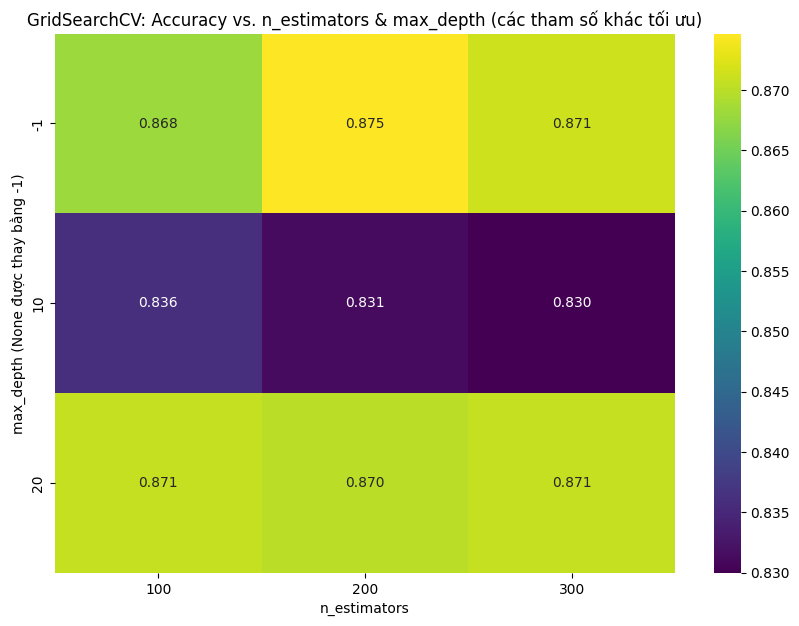

In [14]:
results_df = pd.DataFrame(grid_search_rf.cv_results_)

if 'param_n_estimators' in results_df.columns and 'param_max_depth' in results_df.columns:
    try:
        other_best_params = {k: v for k, v in grid_search_rf.best_params_.items() if k not in ['n_estimators', 'max_depth']}
        
        query_parts = []
        for param_name, param_value in other_best_params.items():
            col_name = 'param_' + param_name
            if param_value is None: # Xử lý giá trị None
                 query_parts.append(f"`{col_name}`.isnull()")
            elif isinstance(param_value, str):
                 query_parts.append(f"`{col_name}` == '{param_value}'")
            else:
                 query_parts.append(f"`{col_name}` == {param_value}")
        
        filtered_results_df = results_df.query(" & ".join(query_parts)) if query_parts else results_df.copy()

        if not filtered_results_df.empty:
            filtered_results_df['param_max_depth_numeric'] = filtered_results_df['param_max_depth'].apply(lambda x: -1 if x is None else x)

            pivot_table = filtered_results_df.pivot_table(
                values='mean_test_score', 
                index='param_max_depth_numeric', 
                columns='param_n_estimators'
            )
            
            plt.figure(figsize=(10, 7))
            sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
            plt.title('GridSearchCV: Accuracy vs. n_estimators & max_depth (các tham số khác tối ưu)')
            plt.xlabel('n_estimators')
            plt.ylabel('max_depth (None được thay bằng -1)')
            plt.show()
        else:
            print("Không thể tạo pivot table, có thể do không có đủ kết hợp tham số sau khi lọc.")

    except Exception as e:
        print(f"Lỗi khi tạo heatmap GridSearchCV: {e}")
        print("Có thể do cấu trúc của param_grid hoặc cv_results_.")
        print("Một số giá trị tham số (ví dụ: None cho max_depth) cần xử lý đặc biệt khi tạo pivot table.")
else:
    print("Không đủ thông tin 'param_n_estimators' hoặc 'param_max_depth' trong cv_results_ để tạo heatmap.")


Thông số mô hình RF tốt nhất: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Điểm CV của mô hình RF tốt nhất: 0.8747
Độ chính xác của mô hình RF tốt nhất trên tập Test: 0.8840

Báo cáo phân loại trên tập Test (Mô hình RF tốt nhất):
              precision    recall  f1-score   support

   asparagus       0.83      0.91      0.87       150
      banana       0.89      0.77      0.82       150
    broccoli       0.91      0.91      0.91       150
      carrot       0.86      0.87      0.86       150
        corn       0.79      0.83      0.81       150
    eggplant       0.92      0.94      0.93       150
      orange       0.94      0.88      0.91       150
   pineapple       0.91      0.86      0.88       150
      potato       0.93      0.91      0.92       150
      tomato       0.88      0.95      0.91       150

    accuracy                           0.88      1500
   macro avg       0.89      0.88      0.88      150

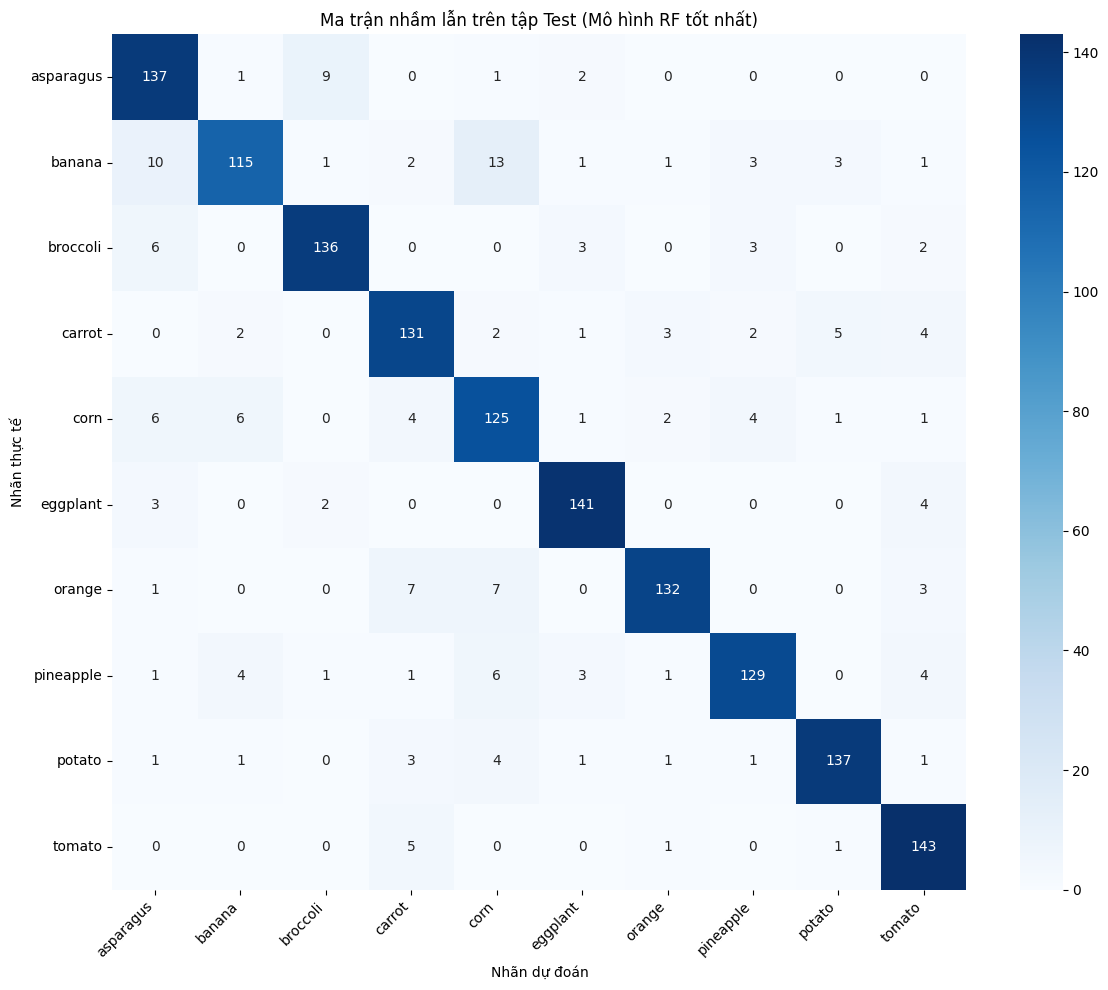

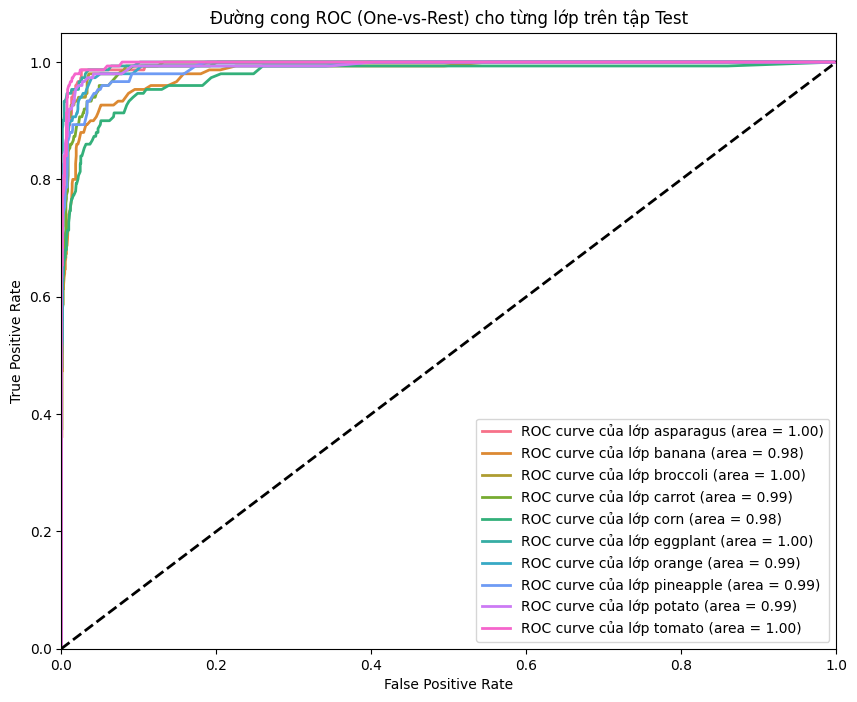

In [15]:
overall_best_model_rf = best_rf_model

y_pred_test_rf = overall_best_model_rf.predict(X_test_processed_rf)
y_prob_test_rf = overall_best_model_rf.predict_proba(X_test_processed_rf)
final_test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)

print(f"\nThông số mô hình RF tốt nhất: {grid_search_rf.best_params_}")
print(f"Điểm CV của mô hình RF tốt nhất: {grid_search_rf.best_score_:.4f}")
print(f"Độ chính xác của mô hình RF tốt nhất trên tập Test: {final_test_accuracy_rf:.4f}")

print("\nBáo cáo phân loại trên tập Test (Mô hình RF tốt nhất):")
print(classification_report(y_test, y_pred_test_rf, target_names=class_names, zero_division=0))

# 7.1. Ma trận nhầm lẫn
cm_final_rf = confusion_matrix(y_test, y_pred_test_rf)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_final_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực tế')
plt.title('Ma trận nhầm lẫn trên tập Test (Mô hình RF tốt nhất)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 7.2. Đường cong ROC và AUC (One-vs-Rest cho đa lớp)
y_test_binarized = label_binarize(y_test, classes=np.arange(len(class_names)))
n_classes_roc = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes_roc):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob_test_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = sns.color_palette("husl", n_classes_roc)

for i, color in zip(range(n_classes_roc), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve của lớp {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Đường cong ROC (One-vs-Rest) cho từng lớp trên tập Test')
plt.legend(loc="lower right")
plt.show()

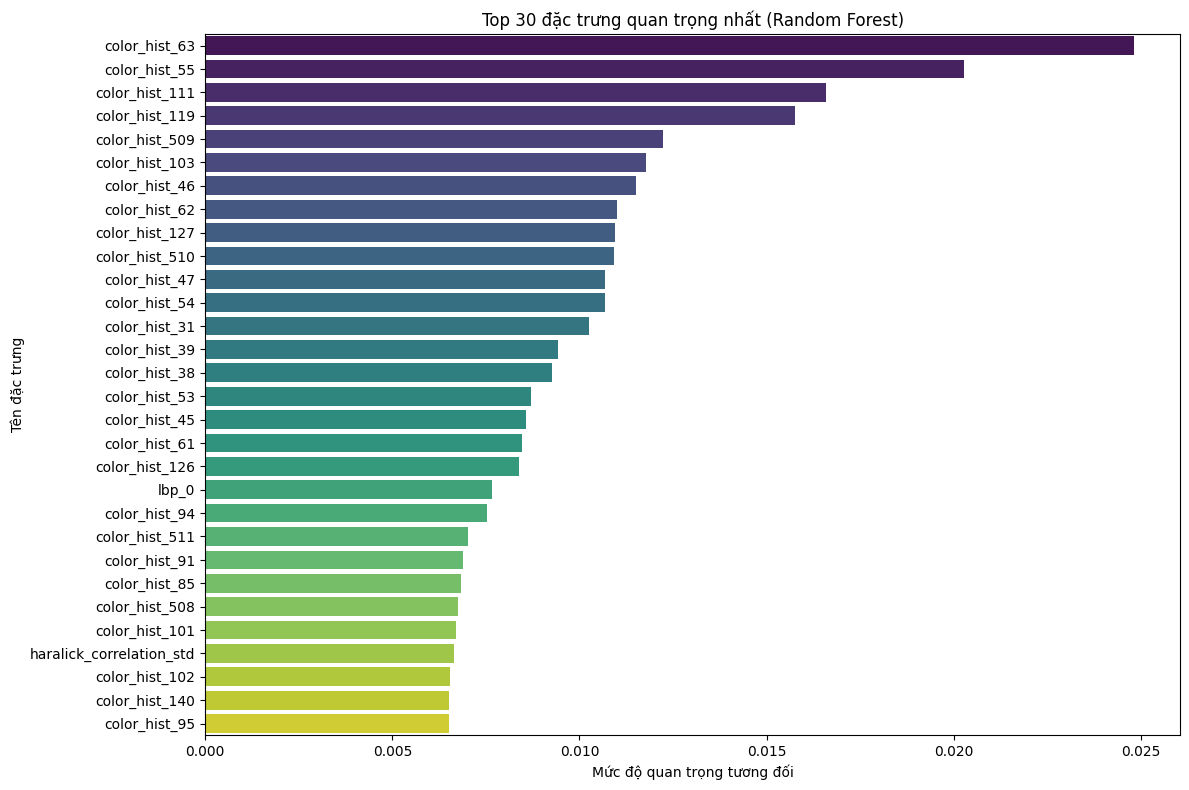


Top 30 đặc trưng quan trọng nhất:
                      feature  importance
63              color_hist_63    0.024811
55              color_hist_55    0.020284
111            color_hist_111    0.016594
119            color_hist_119    0.015753
509            color_hist_509    0.012234
103            color_hist_103    0.011787
46              color_hist_46    0.011516
62              color_hist_62    0.011013
127            color_hist_127    0.010947
510            color_hist_510    0.010918
47              color_hist_47    0.010684
54              color_hist_54    0.010681
31              color_hist_31    0.010254
39              color_hist_39    0.009417
38              color_hist_38    0.009262
53              color_hist_53    0.008715
45              color_hist_45    0.008567
61              color_hist_61    0.008461
126            color_hist_126    0.008381
524                     lbp_0    0.007676
94              color_hist_94    0.007535
511            color_hist_511    0.007011

In [16]:
if X_train_processed_rf.shape[1] == len(feature_names_list) and feature_names_list:
    importances = overall_best_model_rf.feature_importances_
    
    feature_importances_df = pd.DataFrame({
        'feature': feature_names_list,
        'importance': importances
    }).sort_values('importance', ascending=False)

    num_features_to_plot = min(30, len(feature_names_list)) # Hiển thị top 20 hoặc ít hơn

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances_df.head(num_features_to_plot), palette="viridis")
    plt.title(f'Top {num_features_to_plot} đặc trưng quan trọng nhất (Random Forest)')
    plt.xlabel("Mức độ quan trọng tương đối")
    plt.ylabel("Tên đặc trưng")
    plt.tight_layout()
    plt.show()
    
    print("\nTop 30 đặc trưng quan trọng nhất:")
    print(feature_importances_df.head(30))
else:
    print("\nKhông thể hiển thị tầm quan trọng của đặc trưng ban đầu do PCA đã được áp dụng hoặc danh sách tên đặc trưng không khớp.")
    if hasattr(overall_best_model_rf, 'feature_importances_'):
        importances = overall_best_model_rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        num_features_to_plot = min(20, len(importances))
        
        plt.figure(figsize=(12, 6))
        plt.title(f"Top {num_features_to_plot} Feature Importances (sau PCA)")
        pca_feature_names = [f"PC_{i}" for i in range(len(importances))]
        named_importances = pd.Series(importances, index=pca_feature_names).iloc[indices[:num_features_to_plot]]
        sns.barplot(x=named_importances.values, y=named_importances.index)
        plt.xlabel("Relative Importance")
        plt.ylabel("Principal Component")
        plt.tight_layout()
        plt.show()

model_filename_rf = 'final_best_rf_model_vegetables.joblib'
joblib.dump(overall_best_model_rf, model_filename_rf)
print(f"Mô hình RF tốt nhất đã được lưu vào {model_filename_rf}")

if 'scaler_rf' in globals() or 'scaler_rf' in locals():
    scaler_filename_rf = 'final_rf_scaler_vegetables.joblib'
    joblib.dump(scaler_rf, scaler_filename_rf)
    print(f"Scaler của RF đã được lưu vào {scaler_filename_rf}")